# ACS2 vs ACS2ER in Maze

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lcs.metrics import population_metrics

# Load environments
import gym
import gym_maze
import gym_woods
from lcs import Perception

from lcs.agents.acs2 import ACS2, Configuration as CFG_ACS2
from lcs.agents.acs2er import ACS2ER, Configuration as CFG_ACS2ER


# EXPERIMENT CONFIGURATION

In [2]:
EXPLORE_TRIALS = 5000
EXPLOIT_TRIALS = 10

#MAZE = "Woods14-v0"
MAZE = "Maze5-v0"

# # The size of ER replay memory buffer
# ER_BUFFER_SIZE=250
# # The minimum number of samples of ER replay memory buffer to start replying samples (warm-up phase)
# ER_BUFFER_MIN_SAMPLES=25
# # The number of samples to be replayed druing ER phase
# ER_SAMPLES_NUMBER=3


## Metrics and helpers

In [3]:
def _maze_knowledge(population, environment) -> float:
    transitions = environment.env.get_transitions()

    # Take into consideration only reliable classifiers
    reliable_classifiers = [c for c in population if c.is_reliable()]

    # Count how many transitions are anticipated correctly
    nr_correct = 0

    # For all possible destinations from each path cell
    for start, action, end in transitions:

        p0 = environment.env.maze.perception(start)
        p1 = environment.env.maze.perception(end)

        if any([True for cl in reliable_classifiers
                if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions) * 100.0

from lcs.metrics import population_metrics

def _maze_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': _maze_knowledge(pop, env)
    }

    # Add basic population metrics
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Results arrays

ACS2 Experiments

In [4]:

### ACS2 ###
# Load desired environment

# Initialize environment
maze = gym.make(MAZE)

# Create agent 
cfg_acs2 = CFG_ACS2(classifier_length=8,
                    number_of_possible_actions=8,
                    epsilon=0.5,
                    do_ga=False,
                    do_pee=False,
                    metrics_trial_frequency=1,

                    user_metrics_collector_fcn=_maze_metrics)
agent_acs2 = ACS2(cfg_acs2)
# Explore the environment
acs2_explore_metrics = agent_acs2.explore(maze, EXPLORE_TRIALS)
# Exploit the environment
acs2_exploit_metrics = agent_acs2.exploit(maze, EXPLOIT_TRIALS)


ACS2ER Experiments

In [31]:
# ### ACS2ER ###
# # Load desired environment
# mp = MpxObservationWrapper(gym.make(F'boolean-multiplexer-{BITS}bit-v0'))
# # Create agent ACS2ER
# cfg_acs2er = CFG_ACS2ER(classifier_length=mp.env.observation_space.n,
#                     number_of_possible_actions=2,
#                     do_ga=True,
#                     metrics_trial_frequency=10,
#                     er_buffer_size=ER_BUFFER_SIZE,
#                     er_min_samples=ER_BUFFER_MIN_SAMPLES,
#                     er_samples_number=ER_SAMPLES_NUMBER,
#                     user_metrics_collector_fcn=mpx_metrics)
# agent_acs2er = ACS2ER(cfg_acs2er)
# # Explore the environment
# acs2er_explore_metrics = agent_acs2er.explore(mp, EXPLORE_TRIALS)
# # Exploit the environment
# acs2er_exploit_metrics = agent_acs2er.exploit(mp, EXPLOIT_TRIALS)

    

In [6]:
RELIABLE_KEY = "reliable"
KNOWLEDGE_KEY = "knowledge"


def extract_number_of_reliable_cl(metrics):
    return list(map(lambda m: m[RELIABLE_KEY], metrics))

def extract_knowledge(metrics):
    return list(map(lambda m: m[KNOWLEDGE_KEY], metrics))

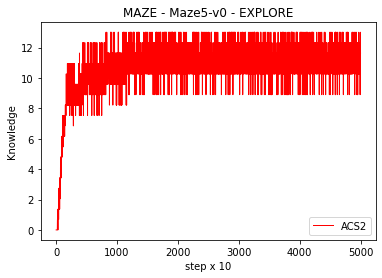

In [7]:
acs2_knowledge = extract_knowledge(acs2_explore_metrics)
# acs2er_reliable = extract_number_of_reliable_cl(acs2er_explore_metrics)

x_axis = range(len(acs2_knowledge))

plt.title(f"MAZE - {MAZE} - EXPLORE")
plt.plot(x_axis, acs2_knowledge, c='r', label="ACS2", linewidth=1.0)
# plt.plot(x_axis, acs2er_reliable, c='b', label="ACS2ER", linewidth=1.0)
plt.legend()
plt.xlabel("step x 10")
plt.ylabel("Knowledge")
plt.show()
# plt.savefig(f"EXPLORE_{RUN}.png")

